## 线性回归
 

In [13]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import random

**生成数据集**

样本数为1000，每个样本有2个特征。

使用的线性回归的权重w=\[2,-3.4\],b=4.2。


In [14]:
# gene true dataSet
num_feature=2
num_example=1000
true_w=[2,-3.4]
true_b=4.2

dataset=torch.randn(num_example,num_feature,dtype=torch.float32)

labels=true_w[0]*dataset[:,0]+true_w[1]*dataset[:,1]+true_b

# 给label，添加一些随机噪声：服从均值为0，标准差为0.01的正态分布
labels+=torch.tensor(np.random.normal(0,0.01),dtype=torch.float32)

print(dataset[0],labels[0])

tensor([0.9017, 0.7498]) tensor(3.4602)


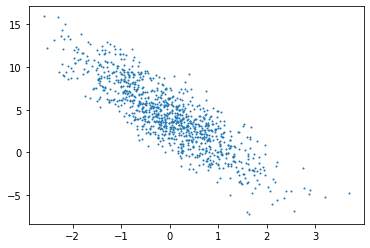

In [15]:
# 查看dataset[:,1]与labels的散点图
plt.scatter(dataset[:, 1].numpy(), labels.numpy(),1)

**读取数据**

定义一个函数：每次返回batch_size(批量大小)个随机样本的特征和标签。

In [16]:
def data_iter(batch_size,dataset,labels):
    num_example=len(dataset)
    idxs=list(range(num_example))
    # 随机选择
    random.shuffle(idxs)
    # 得到batch_size个样本
    # 下次从yield的位置，继续循环，取batch_size个
    for i in range(0,num_example,batch_size):
        end=min(i+batch_size,num_example)
        j=torch.LongTensor(idxs[i:end])
        # print("j:",j)
        # dataset.index_select(0,j)中的0表示按行索引
        yield dataset.index_select(0,j),labels.index_select(0,j)

In [17]:
# test
batch_size=10
for X,y in data_iter(batch_size,dataset,labels):
    print(X,y)
    break

tensor([[ 1.2591, -0.7291],
        [-0.3737, -0.2698],
        [-0.0311,  0.7903],
        [ 1.6058, -1.3352],
        [ 3.1492,  0.3889],
        [ 0.0896, -0.2378],
        [-0.7270,  0.4607],
        [-0.0639, -0.0812],
        [-0.7965, -0.9389],
        [-1.0352, -2.1306]]) tensor([ 9.2033,  4.3764,  1.4571, 11.9577,  9.1825,  5.1939,  1.1857,  4.3545,
         5.8055,  9.3799])


**模型初始化**

In [18]:
w=torch.tensor(np.random.normal(0,0.01,
        size=(num_feature,1)),
    dtype=torch.float32)
b=torch.zeros(1,dtype=torch.float32)

print("w:",w)
print("b:",b)

w: tensor([[ 0.0140],
        [-0.0011]])
b: tensor([0.])


In [19]:
# 模型训练中，需要对参数w和b，求梯度
w.requires_grad=True
b.requires_grad=True

### 定义模型

In [20]:
# 计算预测值

def linreg(X,w,b):
    # 矩阵运算torch.mm()
    return torch.mm(X,w)+b

In [21]:
# 计算损失:平方差损失

def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2/2

In [22]:
# 定义优化函数

def sgd(params,lr,batch_size):
    # prams为[w,b],
    # lr为超参数学习率
    for param in params:
        # 使用梯度,直接更改[w,b]参数
        # 这里要使用.data
        param.data-=lr*param.grad/batch_size

### 训练模型

In [23]:
# hyperparments

# learning rate
lr=0.03
# iter period
num_epochs=3

# net
net=linreg
# loss function
loss=squared_loss

# 一共迭代iterm次数
for epoch in range(num_epochs):
    # 每一个迭代周期内，都会使用训练集中所有的样本依次
    for X,y in data_iter(batch_size,dataset,labels):
        # 损失l是小批量X，y的损失
        l=loss(net(X,w,b),y).sum()
        # 小批量损失，对模型参数求梯度
        l.backward()
        # 使用小批量随机梯度下降，迭代模型参数
        sgd([w,b],lr,batch_size)

        # 梯度清零，防止累加
        w.grad.data.zero_()
        b.grad.data.zero_()
    # 计算一次迭代周期完毕之后的损失值
    train_loss=loss(net(dataset,w,b),labels)
    # tensormean().item()是将一个tensor标量，转为python数值
    print('epoch %d, loss %f'%(epoch+1,train_loss.mean().item()))

epoch 1, loss 0.039508
epoch 2, loss 0.000102
epoch 3, loss 0.000000


**查看参数**

训练完毕之后，就可以直接查看得到的参数w和b

In [25]:
print(true_w,'\n',w)
print(true_b,'\n',b.item())  # b.item()将一个张量类型，转为数值型

[2, -3.4] 
 tensor([[ 1.9999],
        [-3.3993]], requires_grad=True)
4.2 
 4.205831527709961


In [31]:
# print(w.numpy())   /error ,因为w带有梯度信息，强行转换会造成破坏计算图，可以使用clone，保存一个副本
w_cp=w.clone()
print(w_cp.detach().numpy())

[[ 1.9999079]
 [-3.399349 ]]
